## Predicting a Successful New York Times Article Comment

### IPython Process Book

Welcome! Below you will find our iPython process book for our AC209 final project. This process book details our steps in developing our solution, how we collected the data, statistical methods we used, and the insights we found. This process book describes and documents what we explored at each step of our project. Specifically, this process book follows the following topics:


<strong>Overview and Motivation</strong>: Provide an overview of the project goals and the motivation for it. Consider that this will be read by people who did not see your project proposal.

<strong>Related Work</strong>: Anything that inspired you, such as a paper, a web site, or something we discussed in class.

<strong>Initial Questions</strong>: What questions are you trying to answer? How did these questions evolve over the course of the project? What new questions did you consider in the course of your analysis?

<strong>Data</strong>: Source, scraping method, cleanup, storage, etc.

<strong>Exploratory Data Analysis</strong>: What visualizations did you use to look at your data in different ways? What are the different statistical methods you considered? Justify the decisions you made, and show any major changes to your ideas. How did you reach these conclusions?

<strong>Final Analysis</strong>: What did you learn about the data? How did you answer the questions? How can you justify your answers?

<strong>Presentation</strong>: Present your final results in a compelling and engaging way using text, visualizations, images, and videos on your project web site.

# Overview and Motivation

As one of the most popular online news entities*, The New York Times (NYT) attracts thousands of unique visitors each day to its website, nytimes.com. Users who visit the site can provide their thoughts and reactions to published content in the form of comments. 

Users can interact with published comments, by either replying back or recommending a comment (i.e., similar to a 'like' on Facebook) as high quality. The very best comments are picked by NYT staff and marked as NYT picks. We noticed that highly recommended comments and NYT picks comments tend to be significantly longer, more thoughtful, and of high quality compared to the majority of other internet comments.

We aim to examine the relationship between comment success (i.e., number of recommendations by other users and if selected as a NYT pick) and various features of the comment itself. This way, we will be able to produce a model that can predict the success of a given comment. This is important as the comment section enables visitors to further interact with NYT content as it can act as a forum for the exchange of ideas, thoughts, and opinions. 

Successful comments can become more visible on the site. Thus, understanding what could make a succesfful comment is important for both content providers and commentors. Providers can provide better comment guidelines and suggestions to its audience in an attempt to increase the quality of content exchanged on message boards. Additionally, since a NYT moderator must manually approve or reject each submitted comment, a provisional comment ranking system could enable a quicker means to approve good comments. An effective prediction system could also be used in an automated comment recommender to help steer users toward higher quality content. 

*http://www.journalism.org/media-indicators/digital-top-50-online-news-entities-2015/

# Related Work

We are all avid readers of the New York Times and find the comment section to be a great launching pad for further discussion and debate. Andrew was on the leadership board of The Harvard Crimson, so he has experienced journalism first-hand.

While we have not encountered any work that specifically looks at what makes a successful comment on a news site such as that of the NYT, our work is built upon methods that are not new. Speciifcally, we aim to employ sentiment analysis, latent dirichlet allocation (LDA), and decision tree regression in our analysis. 

Insert summary and link to a sentiment analysis paper

http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf

http://www.cs.cornell.edu/home/llee/papers/cutsent.pdf

Insert summary and link to LDA paper

https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf

http://ai.stanford.edu/~ang/papers/nips01-lda.pdf



# Initial Questions

Our main goal is to predict how many recommendations a comment it will receive and if it will be designated as a NYT pick based on the comment's text. Additionally, we aim to quantitatively examine what makes a successful and highly rated comment. For example, do longer comments fare better? Does average word or sentence length play a role? Does the sentiment of the comment have an effect?



# Data

We obtained the comment data from the New York Times' API. The API operates similarly to the Huffington Post API that was used earlier in the course. Initially, we planned to gather 300 comments per day (12 requests per day at 25 comments per request) from Nov 1, 2014 to Nov 15, 2015. However, we ran into issues caused by the API frequently and unpredictably returning a link to the [New York Times generic error page](http://www.nytimes.com/content/help/error.html) (note that this returns an HTTP response code of 200 (OK), in contrast to errors resulting from exceeding rate limits or server errors, which return 400, 404, or 500 response codes). Often, trying a specific query again would succeed, but for several dates, we found ourselves totally unable to extract any comments at all.

The code below is highly robust against these sorts of errors. For each search, it tries four times to get a valid response, with short waits in between each try. Failing that, it moves on to the next date in the range, dumping that day's comments, if any are found, into a file. This ensures that if the script crashes during execution, it will lose at most one day's worth of results. This produces one JSON file for each day, so we then combine all these files into one large file. Finally, we put all the comments into a data frame.

In [2]:
from datetime import date, datetime, timedelta
import requests, time, simplejson, sys, re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.cross_validation import train_test_split
from scipy.sparse import csr_matrix as csr
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb
sns.set_style("darkgrid")
%matplotlib inline

## Scraping

In [ ]:
# perdelta function taken from http://stackoverflow.com/a/10688060

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [ ]:
# Scrape 300 comments per day

for da in perdelta(date(2015, 2, 21), date(2015, 11, 1), timedelta(days=1)):
    comments = []
    print da
    skip = False
    gotany = True
    for i in range(12): # collect 25 comments at a time for 12 times. 25*12 = 300 comments
        if not skip:
            success = False
            count = 0
            url = ('http://api.nytimes.com/svc/community/v3/user-content/' +
                   'by-date.json?api-key=KEY&date=' + str(da) +
                   '&offset=' + str(25*i))
            while not success:
                comments_data = requests.get(url)
                try:
                    data = simplejson.loads(comments_data.content)
                    success = True # go to the next offset
                    for d in data['results']['comments']:
                        comments.append(d)
                    time.sleep(2)
                except:
                    print 'error on {}'.format(str(da))
                    print url
                    count += 1
                    if count > 3:
                        success = True # not really
                        skip = True # just skip to the next day
                        if i == 0:
                            gotany = False # if we didn't get any comments from that day
                    time.sleep(2)
                    
    if gotany:      
        filestr = 'comments {}.json'.format(str(da))
        with open(filestr, 'w') as f:
            simplejson.dump(comments, f)

In [ ]:
# Combine all the JSON lists into single JSON file
# Don't have to worry about failed comment collections thanks to try/except. If we didn't collect the comments
# for a given day, the file load fails and it moves on.

allcomments = []

for d in perdelta(date(2014, 1, 1), date(2015, 12, 31), timedelta(days=1)):
    try:
        with open('json_files/comments {}.json'.format(str(d))) as f:
            c = simplejson.load(f)
            allcomments.extend(c)
    except:
        pass

In [3]:
# store/load the aggregated JSON file
# with open ('comment_data.json', 'w') as f:
#     simplejson.dump(allcomments, f)

with open('comment_data.json', 'r') as f:
    comments = simplejson.load(f)

## Parsing the data

In [4]:
#Convert data into a dataframe 
commentsdicts=[]
for c in comments:
    d={}
    d['approveDate']=c['approveDate']
    d['assetID']=c['assetID']
    d['assetURL']=c['assetURL']
    d['commentBody']=c['commentBody'].replace("<br/>"," ")
    #calculate word count by splitting on spaces. 
    #Account for weird grammar by turning double, triple etc... spaces into single spaces.
    #d['nopunc']=c['commentBody'].replace("%","").replace("&","").replace("!","").replace("?","").replace(",","").replace("'","").replace(".","").replace(":","").replace(";","").replace("    "," ").replace("   "," ").replace("  "," ").replace(" ","")
    d['commentWordCount'] = len(c['commentBody'].replace("<br/><br/>"," ").replace("    "," ").replace("   "," ").replace("  "," ").split(" "))
    d['averageWordLength'] = float(len(c['commentBody'].replace("%","").replace("&","").replace("!","").replace("?","").replace(",","").replace("'","").replace(".","").replace(":","").replace(";","").replace("    "," ").replace("   "," ").replace("  "," ").replace(" ","")))/d["commentWordCount"]
    d['commentID']=c['commentID']
    d['commentSequence']=c['commentSequence']
    d['commentTitle']=c['commentTitle']
    d['createDate']=c['createDate']
    d['editorsSelection']=c['editorsSelection']
    d['lft']=c['lft']
    d['parentID']=c['parentID']
    d['recommendationCount']=c['recommendationCount']
    d['replies']=c['replies']
    d['replyCount']=c['replyCount']
    d['rgt']=c['rgt']
    d['status']=c['status']
    d['statusID']=c['statusID']    
    d['updateDate']=c['updateDate']        
    d['userDisplayName']=c['userDisplayName']
    d['userID']=c['userID']
    d['userLocation']=c['userLocation']
    d['userTitle']=c['userTitle']
    d['userURL']=c['userURL']    
    commentsdicts.append(d)  
commentsdf=pd.DataFrame(commentsdicts)

In [5]:
commentsdf.head()

,approveDate,assetID,assetURL,averageWordLength,commentBody,commentID,commentSequence,commentTitle,commentWordCount,createDate,editorsSelection,lft,parentID,recommendationCount,replies,replyCount,rgt,status,statusID,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1392613210,3394666,http://wordplay.blogs.nytimes.com/2014/02/15/p...,4.243243,"pj, I love that your reply came up 3 times. Ha...",11177402,11177402,<br/>,37,1392613164,0,113,11175397,0,[],0,114,approved,2,1392613210,Leapfinger,51284005,"Durham, NC",NULL,NULL
1,1392613221,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.811594,I definitely agree that the reporter interview...,11177324,11177324,n/a,69,1392611149,0,408,NaN,26,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,411,approved,2,1392613221,Casey L.,52213450,"Tallahassee, FL",NULL,NULL
2,1392613225,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,3.600000,"Well said, CF. Well said.",11177331,11177331,<br/>,5,1392611304,0,303,11176805,8,[],0,304,approved,2,1392613225,Dana,60343880,"Tucson, AZ",NULL,NULL
3,1392613303,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.701149,"Who are these people who are commenting, so sm...",11177382,11177382,<br/>,174,1392612709,0,412,NaN,104,"{u'comments': [{u'recommendedFlag': 0, u'paren...",3,419,approved,2,1392613303,JM4,6671866,"Bellingham, WA",NULL,NULL
4,1392613365,3394610,http://www.nytimes.com/2014/02/16/nyregion/add...,4.463415,"To all you pain suffers, let me tell to you my...",11177369,11177369,<br/>,164,1392612359,0,294,NaN,2,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,297,approved,2,1392613365,Vincent from Westchester,56242144,White Plains,NULL,NULL


#  Exploratory Analysis

The first thing we did in our exploratory analysis was to call the describe method to get an initial read on what we were working with. From the below, we can see that we have ~180,000 comments, where the average comment is approximatley 83 words in length. Based on our number of comments per user ID calculations, we see that the majority of users only write a single comment (though, there is one outlier who has written 820!). In terms of recommendation count, we see that the average comment receives 24 recommendations and the maximum number of recommendations received by any single comment was 3064. With respect to the editors selection designation, a binary indicator, we see that the mean is 0.026, which implies that just under 3% of our comments receive the editors selection designation.  

#### Describe the data

In [6]:
#describe the recommendation count data
commentsdf["recommendationCount"].describe()

count    179650.000000
mean         23.737050
std          75.944896
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max        3064.000000
Name: recommendationCount, dtype: float64

In [7]:
#describe the editor selection data
commentsdf["editorsSelection"].describe()

count    179650.000000
mean          0.026680
std           0.161146
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: editorsSelection, dtype: float64

In [8]:
#describe the comment word count data
commentsdf["commentWordCount"].describe()

count    179650.000000
mean         81.849179
std          67.587734
min           1.000000
25%          30.000000
50%          61.000000
75%         114.000000
max         699.000000
Name: commentWordCount, dtype: float64

In [9]:
#calculate number of comments per user
groupByUser = commentsdf.groupby("userID")
commentsPerUser = [i for i in groupByUser.count().commentID]
print "mean number of comments per user: ", np.mean(commentsPerUser)
print "median number of comments per user: ", np.median(commentsPerUser)
print "minimum number of comments per user: ", min(commentsPerUser)
print "maximum number of comments per user: ", max(commentsPerUser)

mean number of comments per user:  3.84056266969
median number of comments per user:  1.0
minimum number of comments per user:  1
maximum number of comments per user:  820


#### Plot Histograms

Next we plotted several histograms to gain a better underestanding of the data. The plots support the information above, where 75% of of comments have 16 or fewer comments.

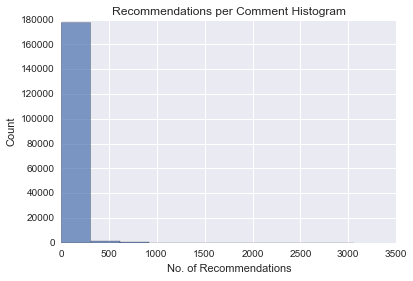

In [10]:
#plot histogram of number of recommendations a comment receives

plt.hist(commentsdf["recommendationCount"],alpha = .7)
plt.title("Recommendations per Comment Histogram")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.show()

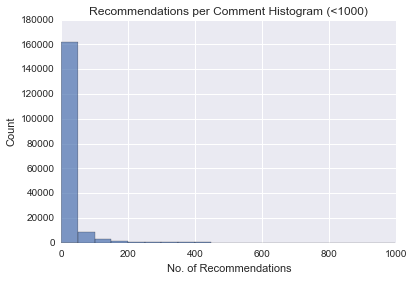

In [11]:
#focus our histogram to recommendation counts less than 1000 since the above plot is not very informative

focusedDf = commentsdf[commentsdf["recommendationCount"] < 1000]
plt.hist(focusedDf.recommendationCount, bins=20, alpha = .7)
plt.title("Recommendations per Comment Histogram (<1000)")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.show()

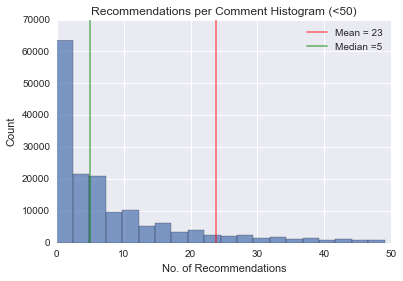

In [12]:
#focus our histogram even more to recommendation counts less than 50 for best visibility into the majority of the data

focusedDf = commentsdf[commentsdf["recommendationCount"] < 50]
plt.hist(focusedDf.recommendationCount, bins=20,alpha=.7)
plt.axvline(23.73,color = 'r',alpha = .5,label = 'Mean = 23')
plt.axvline(5,color = 'g',alpha = .5,label = 'Median =5')
plt.title("Recommendations per Comment Histogram (<50)")
plt.ylabel("Count")
plt.xlabel("No. of Recommendations")
plt.legend()
plt.show()

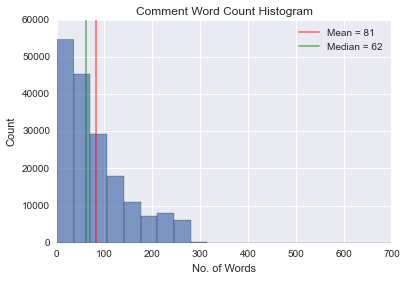

In [13]:
#plot histogram of comment word count to get a sense of how long comments are

plt.hist(commentsdf["commentWordCount"], bins=20, alpha = .7)
plt.title("Comment Word Count Histogram")
plt.axvline(81.32,color = 'r',alpha = .5,label = 'Mean = 81')
plt.axvline(61,color = 'g',alpha = .5,label = 'Median = 62')
plt.ylabel("Count")
plt.xlabel("No. of Words")
plt.legend()
plt.show()

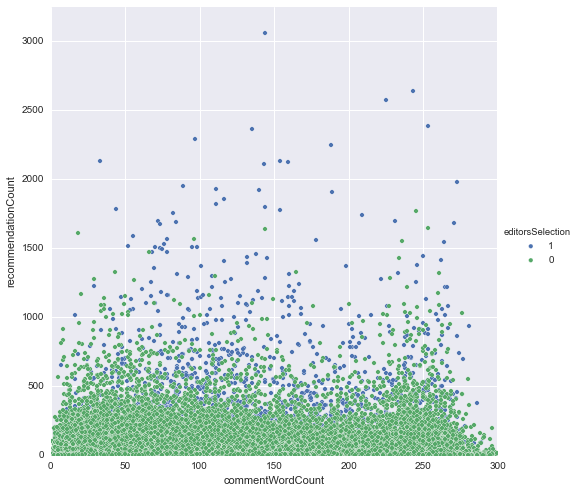

In [14]:
# Pairplot with hue
sns.pairplot(commentsdf, x_vars=['commentWordCount'], y_vars=['recommendationCount'], 
             hue='editorsSelection', hue_order=[1, 0], size=7);
plt.xlim(0, 300);
plt.ylim(0, 3250);

# Feature Selection

We use a variety of features, including
* number of words per comment (Andrew)
* avg. word length (Andrew)
* sentiment of comment (Reinier)
* tf-idf (Jonathan)
* binary bag of words (Jonathan)

In [15]:
# X = N x D (N is number of comments, D is number of features)
# Each person should produce an N x D' matrix where D' is the number of features generated by their analysis.
# Then we np.concatenate the matrices together.

### Sentiment analysis

In [16]:
# Read in the SentiWordNet database (without comments at the top)

sentimentdf = pd.read_csv('SentiWordNet_prepared.txt', sep='\t')  # We stripped comments and the last newline
sentimentdf.head()

,POS,ID,PosScore,NegScore,SynsetTerms,Gloss
0,a,1740,0.125,0.00,able#1,(usually followed by `to') having the necessar...
1,a,2098,0.000,0.75,unable#1,(usually followed by `to') not having the nece...
2,a,2312,0.000,0.00,dorsal#2 abaxial#1,facing away from the axis of an organ or organ...
3,a,2527,0.000,0.00,ventral#2 adaxial#1,nearest to or facing toward the axis of an org...
4,a,2730,0.000,0.00,acroscopic#1,facing or on the side toward the apex


In [17]:
# Clean up different meanings of words into one (the mean score for a word)

sentimentdf.SynsetTerms = sentimentdf.SynsetTerms.apply(lambda words: words.split(' '))
sentimentdf.SynsetTerms = sentimentdf.SynsetTerms.apply(lambda words: [word[:-2] for word in words])
sentimentdf.drop(['POS', 'ID', 'Gloss'], axis=1, inplace=True)

rebuilt = []

for row in sentimentdf.as_matrix():
    positive = row[0]
    negative = row[1]
    words = row[2]
    for word in words:
        entry = (positive, negative, word)
        rebuilt.append(entry)

sentimentdf = pd.DataFrame(rebuilt, columns=['positive', 'negative', 'word'])
sentimentdf = sentimentdf.groupby('word').agg({'positive': np.mean, 'negative': np.mean})
sentimentdf.head(4)

,positive,negative
word,,
'hood,0,0.375
's_gravenhage,0,0.000
'tween,0,0.000
'tween_decks,0,0.000


In [18]:
# Define function to calculate score per comment (avg. positive and negative scores over words)

sentiment = sentimentdf.to_dict(orient='index')
delete_characters = re.compile('\W')

def positive_score(comment):
    commentlist = comment.split(' ')
    commentlist = map(lambda s: re.sub(delete_characters, '', s).lower(), commentlist)
    score = 0.0
    number = 0
    for word in commentlist:
        if word in sentiment:
            score +=sentiment[word]['positive']
            number += 1
    if number > 0:
        return score/number
    else:
        return 0

def negative_score(comment):
    commentlist = comment.split(' ')
    commentlist = map(lambda s: re.sub(delete_characters, '', s).lower(), commentlist)
    score = 0.0
    number = 0
    for word in commentlist:
        if word in sentiment:
            score +=sentiment[word]['negative']
            number += 1
    if number > 0:
        return score/number
    else:
        return 0

In [19]:
print sentiment['exquisite']

{'positive': 0.4375, 'negative': 0.125}


#### Application to `commentsdf`

In [20]:
# Now we calculate the sentiment score for each comment

commentsdf['positive_sentiment'] = commentsdf.commentBody.apply(positive_score)
commentsdf['negative_sentiment'] = commentsdf.commentBody.apply(negative_score)
commentsdf.head()

# Scroll to the right to see scores -->

,approveDate,assetID,assetURL,averageWordLength,commentBody,commentID,commentSequence,commentTitle,commentWordCount,createDate,editorsSelection,lft,parentID,recommendationCount,replies,replyCount,rgt,status,statusID,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,positive_sentiment,negative_sentiment
0,1392613210,3394666,http://wordplay.blogs.nytimes.com/2014/02/15/p...,4.243243,"pj, I love that your reply came up 3 times. Ha...",11177402,11177402,<br/>,37,1392613164,0,113,11175397,0,[],0,114,approved,2,1392613210,Leapfinger,51284005,"Durham, NC",NULL,NULL,0.068522,0.020037
1,1392613221,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.811594,I definitely agree that the reporter interview...,11177324,11177324,n/a,69,1392611149,0,408,NaN,26,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,411,approved,2,1392613221,Casey L.,52213450,"Tallahassee, FL",NULL,NULL,0.075430,0.033953
2,1392613225,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,3.600000,"Well said, CF. Well said.",11177331,11177331,<br/>,5,1392611304,0,303,11176805,8,[],0,304,approved,2,1392613225,Dana,60343880,"Tucson, AZ",NULL,NULL,0.125000,0.002778
3,1392613303,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.701149,"Who are these people who are commenting, so sm...",11177382,11177382,<br/>,174,1392612709,0,412,NaN,104,"{u'comments': [{u'recommendedFlag': 0, u'paren...",3,419,approved,2,1392613303,JM4,6671866,"Bellingham, WA",NULL,NULL,0.065380,0.040202
4,1392613365,3394610,http://www.nytimes.com/2014/02/16/nyregion/add...,4.463415,"To all you pain suffers, let me tell to you my...",11177369,11177369,<br/>,164,1392612359,0,294,NaN,2,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,297,approved,2,1392613365,Vincent from Westchester,56242144,White Plains,NULL,NULL,0.053066,0.088692


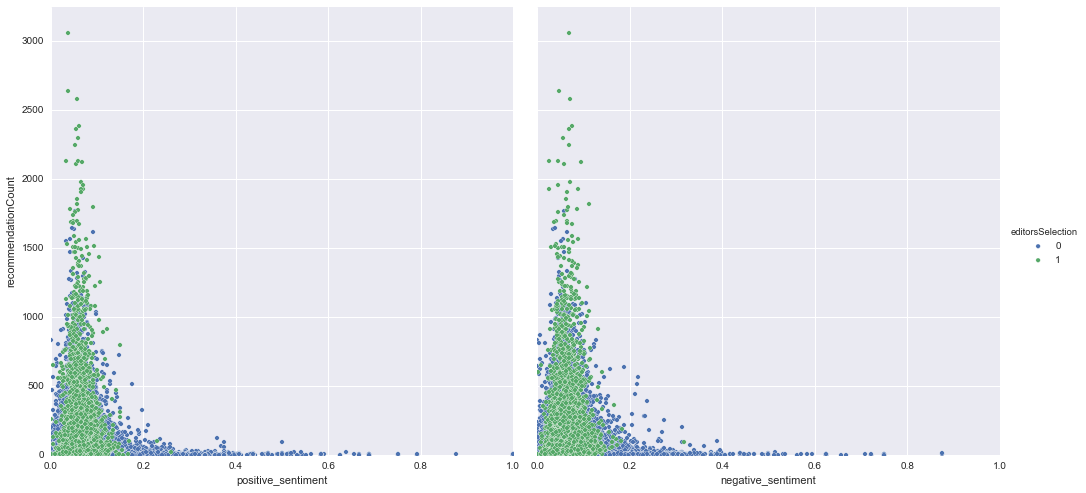

In [21]:
# Checking if the feature looks valid

pair = sns.pairplot(commentsdf, x_vars=['positive_sentiment', 'negative_sentiment'], 
                    y_vars=['recommendationCount'], hue='editorsSelection', size=7);
axes = pair.axes;
axes[0, 0].set_xlim(0, 1);
axes[0, 0].set_ylim(0, 3250);
axes[0, 1].set_xlim(0, 1);
axes[0, 1].set_ylim(0, 3250);

Most recommendations occur for posts with a 0.1 sentiment scrore, either positive or negative.

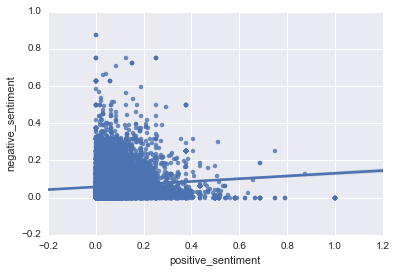

In [22]:
sns.regplot('positive_sentiment', 'negative_sentiment', data=commentsdf);

The features are not strongly correlated, which is good.

### Binary Bag of Words

We use a binary bag of words feature that encodes which of the 100 most popular words appear in a comment.

In [23]:
stop_words = text.ENGLISH_STOP_WORDS.union(['didn', 've', 'don']) # add additional stop words
corpus = commentsdf.commentBody.tolist()
vectorizer = CountVectorizer(stop_words=stop_words, max_features=100, binary=True)
bowmat = vectorizer.fit_transform(corpus) # bag of words matrix
words = vectorizer.vocabulary_.keys()
print words

for i in range(100):
    commentsdf['word{}_{}'.format(i, words[i])] = bowmat[:, i].toarray().flatten()

[u'want', u'wrong', u'problem', u'year', u'american', u'times', u'point', u'today', u'like', u'case', u'long', u'best', u'life', u'people', u'states', u'obama', u'hope', u'change', u'live', u'real', u'read', u'public', u'used', u'doesn', u'target', u'maybe', u'mr', u'end', u'got', u'support', u'country', u'look', u'having', u'isn', u'things', u'care', u'help', u'course', u'president', u'say', u'man', u'thing', u'think', u'going', u'power', u'really', u'great', u'doing', u'work', u'use', u'actually', u'does', u'state', u'did', u'children', u'republicans', u'women', u'years', u'world', u'away', u'america', u'party', u'yes', u'time', u'need', u'republican', u'person', u'sure', u'let', u'bad', u'just', u'fact', u'article', u'new', u'government', u'way', u'war', u'lot', u'make', u'free', u'place', u'political', u'right', u'old', u'big', u'high', u'far', u'law', u'title', u'little', u'better', u'said', u'americans', u'pay', u'good', u'money', u'day', u'come', u'believe', u'know']


### Tf-Idf

We add a column to the dataframe composed of the average tf-idf score over all words in a comment.

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidfmat = tfidf_vectorizer.fit_transform(corpus)
commentsdf['tfidf'] = csr.sum(tfidfmat, axis=1)
commentsdf['tfidf'] = commentsdf['tfidf'].div(commentsdf['commentWordCount'], axis='index')

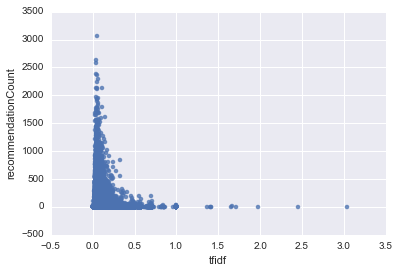

In [25]:
sns.regplot(x='tfidf', y='recommendationCount', data=commentsdf, fit_reg=False)

## Transforming variables

In [39]:
commentsdf['logrecommendationCount'] = np.log(commentsdf.recommendationCount + 1)  # + 1 to deal with log(0)
commentsdf['logtfidf'] = np.log(commentsdf.tfidf)
commentsdf['logpositive'] = np.log(commentsdf.positive_sentiment)
commentsdf['lognegative'] = np.log(commentsdf.negative_sentiment)

# Using arcsinh to easily handle extremities (zeroes)
commentsdf['srecommendationCount'] = np.arcsinh(commentsdf.recommendationCount)
commentsdf['stfidf'] = np.arcsinh(commentsdf.tfidf)
commentsdf['spositive'] = np.arcsinh(commentsdf.positive_sentiment)
commentsdf['snegative'] = np.arcsinh(commentsdf.negative_sentiment)

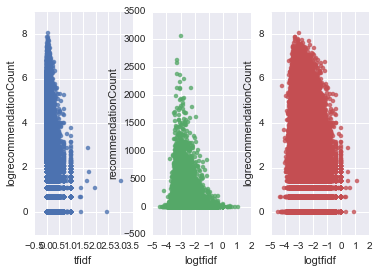

In [40]:
fig, axes = plt.subplots(1, 3)
sns.regplot('tfidf', 'logrecommendationCount', data=commentsdf, fit_reg=False, ax=axes[0])
sns.regplot('logtfidf', 'recommendationCount', data=commentsdf, fit_reg=False, ax=axes[1])
sns.regplot('logtfidf', 'logrecommendationCount', data=commentsdf, fit_reg=False, ax=axes[2])

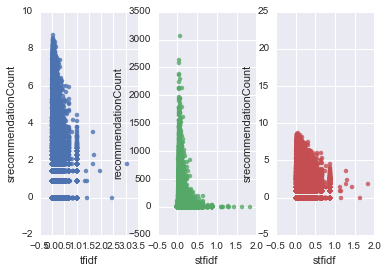

In [41]:
fig, axes = plt.subplots(1, 3)
sns.regplot('tfidf', 'srecommendationCount', data=commentsdf, fit_reg=False, ax=axes[0])
sns.regplot('stfidf', 'recommendationCount', data=commentsdf, fit_reg=False, ax=axes[1])
sns.regplot('stfidf', 'srecommendationCount', data=commentsdf, fit_reg=False, ax=axes[2])

# Final Analysis

### Split data

In [46]:
# First, select relevant columns.
data = commentsdf.ix[:, [3] + [8] + np.arange(25, 128).tolist()].as_matrix()
label = commentsdf.recommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)

### XGBoost

In [ ]:
# XGBoost
dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dtest = xgb.DMatrix(Xtest)

# Set params to try to make the unbalanced dataset less bad
params = {'bst:subsample': 0.7, 'bst:max_delta_step': 3}
bst = xgb.train(params, dtrain, 500)
ypred = bst.predict(dtest)
print np.linalg.norm(ypred - ytest), np.linalg.norm(ypred - ytrain.mean()) # this is very bad

### Linear Regression

In [47]:
regression = LinearRegression()
regression.fit(Xtrain, ytrain)
# y_predicted = regression.predict(Xtest)
print "R-squared:", regression.score(Xtest, ytest)

R-squared: 0.0308410927172


### Random Forest Regressor & Classifier

They are bad.

In [ ]:
rf = RandomForestRegressor(n_estimators=20)
rf.fit(Xtrain, ytrain)
print rf.score(Xtest, ytest)

In [ ]:
binary_label = commentsdf.editorsSelection.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, binary_label)

In [ ]:
rfc = RandomForestClassifier(n_estimators=20)
rf.fit(Xtrain, ytrain)
print rf.score(Xtest, ytest)

### Logistic Regression on Editors Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# I redid test and train...
# First, select relevant columns.
data = commentsdf.ix[:, [3] + [8] + np.arange(25, 128).tolist()].as_matrix()
label = commentsdf.editorsSelection.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)


# Run logistic regression
logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)
ypred = logreg.predict(Xtest)

print "actual number of editors choices ", np.sum(ytest)
print "predicted number of editors choices ", np.sum(ypred)

In [ ]:
# Try adjusting our threshold
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

print "actual number of editors choice",np.sum(ytest)
print "predicted number of editors choices t = 1: ", np.sum(t_repredict(logreg, .95, Xtest))
print "predicted number of editors choices t = 0.5: ", np.sum(t_repredict(logreg, 0.5, Xtest))
print "predicted number of editors choices t = 0.1: ", np.sum(t_repredict(logreg, 0.1, Xtest))
print "predicted number of editors choices t = 0.075: ", np.sum(t_repredict(logreg, 0.075, Xtest))
print "predicted number of editors choices t = 0.05: ", np.sum(t_repredict(logreg, 0.05, Xtest))
print "predicted number of editors choices t = 0.025: ", np.sum(t_repredict(logreg, 0.025, Xtest))

In [ ]:
# We see most of the predicted positives are false positives. only 164 positive positives. 
confusion_matrix(ytest,t_repredict(logreg, 0.075, Xtest))

### Log-lin regression (Poisson)

In [43]:
commentsdf.head()

,approveDate,assetID,assetURL,averageWordLength,commentBody,commentID,commentSequence,commentTitle,commentWordCount,createDate,editorsSelection,lft,parentID,recommendationCount,replies,replyCount,rgt,status,statusID,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,positive_sentiment,negative_sentiment,word0_want,word1_wrong,word2_problem,word3_year,word4_american,word5_times,word6_point,word7_today,word8_like,word9_case,word10_long,word11_best,word12_life,word13_people,word14_states,word15_obama,word16_hope,word17_change,word18_live,word19_real,word20_read,word21_public,word22_used,...,word59_away,word60_america,word61_party,word62_yes,word63_time,word64_need,word65_republican,word66_person,word67_sure,word68_let,word69_bad,word70_just,word71_fact,word72_article,word73_new,word74_government,word75_way,word76_war,word77_lot,word78_make,word79_free,word80_place,word81_political,word82_right,word83_old,word84_big,word85_high,word86_far,word87_law,word88_title,word89_little,word90_better,word91_said,word92_americans,word93_pay,word94_good,word95_money,word96_day,word97_come,word98_believe,word99_know,tfidf,logrecommendationCount,logtfidf,logpositive,lognegative,srecommendationCount,stfidf,spositive,snegative
0,1392613210,3394666,http://wordplay.blogs.nytimes.com/2014/02/15/p...,4.243243,"pj, I love that your reply came up 3 times. Ha...",11177402,11177402,<br/>,37,1392613164,0,113,11175397,0,[],0,114,approved,2,1392613210,Leapfinger,51284005,"Durham, NC",NULL,NULL,0.068522,0.020037,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.087908,0.000000,-2.431464,-2.680603,-3.910165,0.000000,0.087795,0.068468,0.020036
1,1392613221,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.811594,I definitely agree that the reporter interview...,11177324,11177324,n/a,69,1392611149,0,408,NaN,26,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,411,approved,2,1392613221,Casey L.,52213450,"Tallahassee, FL",NULL,NULL,0.075430,0.033953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0.074930,3.295837,-2.591203,-2.584544,-3.382787,3.951613,0.074860,0.075359,0.033946
2,1392613225,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,3.600000,"Well said, CF. Well said.",11177331,11177331,<br/>,5,1392611304,0,303,11176805,8,[],0,304,approved,2,1392613225,Dana,60343880,"Tucson, AZ",NULL,NULL,0.125000,0.002778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.282159,2.197225,-1.265284,-2.079442,-5.886104,2.776472,0.278543,0.124677,0.002778
3,1392613303,3394685,http://www.nytimes.com/2014/02/16/fashion/mill...,4.701149,"Who are these people who are commenting, so sm...",11177382,11177382,<br/>,174,1392612709,0,412,NaN,104,"{u'comments': [{u'recommendedFlag': 0, u'paren...",3,419,approved,2,1392613303,JM4,6671866,"Bellingham, WA",NULL,NULL,0.065380,0.040202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0.043917,4.653960,-3.125462,-2.727533,-3.213831,5.337561,0.043903,0.065334,0.040191
4,1392613365,3394610,http://www.nytimes.com/2014/02/16/nyregion/add...,4.463415,"To all you pain suffers, let me tell to you my...",11177369,11177369,<br/>,164,1392612359,0,294,NaN,2,"{u'comments': [{u'recommendedFlag': 0, u'paren...",1,297,approved,2,1392613365,Vincent from Westchester,56242144,White Plains,NULL,NULL,0.053066,0.088692,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.039264,1.098612,-3.237444,-2.936210,-2.422587,1.443635,0.039254,0.053042,0.088576


In [52]:
# This model does regular log-lin regression
data = commentsdf.ix[:, [3, 8, 25, 26, 127] + range(27, 127)].as_matrix()
label = commentsdf.logrecommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)

regression = LinearRegression()
regression.fit(Xtrain, ytrain)
# y_predicted = regression.predict(Xtest)
print "R-squared:", regression.score(Xtest, ytest)

R-squared: 0.0920920502392


Now we're talking

In [53]:
# This model does arcsinh-lin regression, just to try
data = commentsdf.ix[:, [3, 8, 25, 26, 127] + range(27, 127)].as_matrix()
label = commentsdf.srecommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)

regression = LinearRegression()
regression.fit(Xtrain, ytrain)
# y_predicted = regression.predict(Xtest)
print "R-squared:", regression.score(Xtest, ytest)

R-squared: 0.0890729514935


No improvement...

### Log-log/lin regression (some variables are logged others not)

In [54]:
# This model uses arcsinh to deal with zero values on tfidf and sentiment
data = commentsdf.ix[:, [3, 8, 133, 134, 135] + range(27, 127)].as_matrix()
label = commentsdf.logrecommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)

regression = LinearRegression()
regression.fit(Xtrain, ytrain)
# y_predicted = regression.predict(Xtest)
print "R-squared:", regression.score(Xtest, ytest)

R-squared: 0.0851882105731


Log-log didn't enhance the regression :(

## Rerun Random Forest with logged recommendation count

In [ ]:
data = commentsdf.ix[:, [3, 8, 25, 26, 127] + range(27, 127)].as_matrix()
label = commentsdf.logrecommendationCount.as_matrix()
Xtrain, Xtest, ytrain, ytest = train_test_split(data, label)

rf = RandomForestRegressor(n_estimators=20)
rf.fit(Xtrain, ytrain)
print rf.score(Xtest, ytest)